# 7. Finetuning of the models

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**



**In addition, please download your own local version of the data from https://www.kaggle.com/camnugent/predict-nhl-player-salaries and store it into the folder "data/nhl/nhl_salaries/"**

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from numpy import sqrt
from numpy import argmax

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score


from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file
from metrics import evaluate_model
from metrics import evaluate_model2

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sns.set()

---
## Preparing data used in the previous sections

In [2]:
# read data
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

# drop NaNs, select relevant columns only
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

# Prepare target. Convert categorical event values 'Goal' to a numerical 0/1 value indicating goal
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

# Convert categorical 'secondaryType' column to multiple numerical columns
cat_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)

#balance targets
df = balance_binary_target(df, target='goal')


In [3]:
# adding feature distance
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data_dist = df.copy()
df_data_dist['distance'] = df_data_dist.apply(dist, axis=1)

# cut outliers first
df_data_dist = df_data_dist[df_data_dist.distance<50]

In [4]:
# adding feature angle
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)

# cutting outliers
df_data_dist_angle= df_data_dist_angle[df_data_dist_angle.angle<40]

---
## Adding players to game events

In [5]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)

---
Read and filter the data frame twice, once for skate, once for goalie:

In [6]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

---
Merge both player types with game plays:

In [7]:
# created new table and merge skaters and golies to the game events
df_data_player = df_data_dist_angle.copy()

df_data_player = df_data_player.merge(df_skater, how='left', on='play_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='play_id')

In [8]:
# Apparently not all shots were on goal. No golie then. Keeping this rows anyway but replacing goalie by Zero
df_data_player.goalie_id.fillna(0, inplace=True)

## Adding player statistics

In [9]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')

---
Calculating overall savePercentage for each goalie:

In [10]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)

---
Calculating overall statistics for each skater:

In [11]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)

---
Merging it together in the training dataset

In [12]:
df_data_player = df_data_player.merge(df_skater, how='left', on='skater_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='goalie_id')

In [13]:
df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)

## Adding players salaries

In [14]:
# Data from another dataset
df_players_train = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_players_test = pd.read_csv('data/nhl/nhl_salaries/test.csv')

df_player_stats = pd.concat([df_players_train, df_players_test])

In [15]:
df_player_stats = df_player_stats[['First Name', 'Last Name', 'Nat', 'Salary']].rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality', 'Salary':'salary'})

---
Prepare player_info for merging

In [16]:
df_player_info.rename(columns={'player_id':'skater_id'}, inplace=True)

---
Add additional player's identification data to the target dataset: 

In [17]:
#add name and nationality of the skater
df_data_player = df_data_player.merge(df_player_info[['skater_id', 'firstName', 'lastName', 'nationality']], how='left', on='skater_id')

---
Add salary to the merged dataset:

In [18]:
# add salary based on first name, last name, and the nationality
df_data_player = df_data_player.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])

___
Replace missing salary with median (to ignore outliers):

In [19]:
# replace missing salary
df_data_player.salary.fillna(df_data_player.salary.median(), inplace=True)

df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)

In [20]:
df_dataset = df_data_player.copy()

In [21]:
# cutting outliers
df_dataset = df_dataset[df_dataset.goals<400]
df_dataset = df_dataset[df_dataset.shots<4000]
df_dataset = df_dataset[df_dataset.assists<700]
df_dataset = df_dataset[df_dataset.salary<10000000]



## Re-train models to set benchmark

In [22]:
# starting training with player salary
run_logistic_regression(df_dataset, c_matrix=False, r_curve=False);
run_lightgbm_classifier(df_dataset, c_matrix=False, r_curve=False);

========== Logistic Regression ==========
Accuracy: 0.6066
F1 Score: 0.7551
AUC-ROC Score: 0.5301
-----------------------------------------
Precision: 0.6066
Recall: 1.0000
========== LightGBM Classifier ==========
Accuracy: 0.6518
F1 Score: 0.7484
AUC-ROC Score: 0.6676
-----------------------------------------
Precision: 0.6662
Recall: 0.8537


---
### Experiments with fine tuning
Finetuning experimets using different techniques will be applied


---
---

#### Trying another split of train/test data:

In [23]:
run_logistic_regression(df_dataset, c_matrix=False, r_curve=False, test_size=0.5);
run_lightgbm_classifier(df_dataset, c_matrix=False, r_curve=False, test_size=0.5);

========== Logistic Regression ==========
Accuracy: 0.6093
F1 Score: 0.7572
AUC-ROC Score: 0.5312
-----------------------------------------
Precision: 0.6093
Recall: 1.0000
========== LightGBM Classifier ==========
Accuracy: 0.6506
F1 Score: 0.7482
AUC-ROC Score: 0.6647
-----------------------------------------
Precision: 0.6669
Recall: 0.8522


#### Set training and test data for experiments

In [24]:
target = 'goal'
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove(target)

X_train, X_test, y_train, y_test = train_test_split(df_dataset[features], df_dataset[target], test_size=0.3, random_state=42)


#### Trying to find best threshold for Logistic Regression

In [25]:
# create model
model = LogisticRegression(max_iter=10000);

# fit model
model.fit(X_train,y_train)

preds = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, preds)

evaluate_model(model, X_test, y_test, c_matrix=False, r_curve=False);

Accuracy: 0.6066
F1 Score: 0.7551
AUC-ROC Score: 0.5301
-----------------------------------------
Precision: 0.6066
Recall: 1.0000


In [31]:
evaluate_model(model, X_test, y_test, c_matrix=False, r_curve=False);

Accuracy: 0.6066
F1 Score: 0.7551
AUC-ROC Score: 0.5301
-----------------------------------------
Precision: 0.6066
Recall: 1.0000


In [36]:
# list of g_means
g_means = sqrt(tpr * (1-fpr))
# index of the largest g-mean
idx = argmax(g_means)

print(f'Best threshold = {thresholds[idx]:.4f}')
evaluate_model2(model, X_test, y_test, threshold=thresholds[idx], c_matrix=False, r_curve=False);

Best threshold = 0.6063
Accuracy: 0.5235
F1 Score: 0.5772
AUC-ROC Score: 0.5201
-----------------------------------------
Precision: 0.6251
Recall: 0.5361


In [58]:
f1_score(y_test, model.predict(X_test))

0.7567554252777298

In [60]:
f1_score(y_test, model.predict_proba(X_test)[:,1] > THRESHOLD)

0.5623639413297171

#### Ad-hoc parameters selection for LGBM

In [50]:
grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.75, 0.8, 0.85], 
          'learning_rate': [0.05, 0.1, 0.15], 
          'max_depth': [4, 5, 6], 
          'n_estimators': [80, 100, 120], 
          'num_leaves': [12, 18, 24], 
          'objective': ['binary'], 
          'reg_alpha': [4, 5, 6], 
          'reg_lambda': [4, 5, 6], 
          'seed': [500, 600, 700], 
          'subsample': [0.75]}

model = LGBMClassifier();
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

mod, metrs = evaluate_model(grid, X_test, y_test)

Starting...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 18, 'objective': 'binary', 'reg_alpha': 6, 'reg_lambda': 5, 'seed': 500, 'subsample': 0.75}
0.6604224874917396
Training ran in 2431.61200 seconds


NameError: name 'evaluate_model' is not defined

Compared to the benchmark, a small improvement of the metrics

========== LightGBM Classifier (Benchmark) ==========

Accuracy: 0.6536

F1 Score: 0.7514

AUC-ROC Score: 0.6691



-----------------------------------------

Accuracy: 0.6545
F1 Score: 0.7517
AUC-ROC Score: 0.6714
-----------------------------------------
Precision: 0.6681
Recall: 0.8594


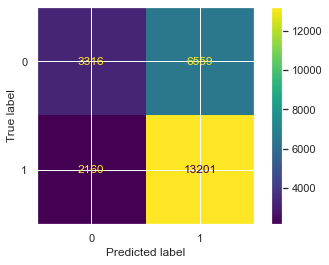

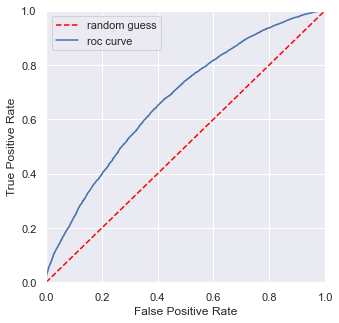

In [52]:
mod, metrs = evaluate_model(grid, X_test, y_test)

In [ ]:
std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()

pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('logistic_Reg', logistic_Reg)])

n_components = list(range(1,X_train.shape[1]+1,1))

C = np.logspace(-4, 4, 50)
penalty = ['l2']

parameters = dict(pca__n_components=n_components,
                  logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty)


clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

In [ ]:
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=19)
lg_model = linear_model.LogisticRegression(max_iter=10000, C=6866.488450042998, penalty='l2')

pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('logistic_Reg', lg_model)])


# fit model
lg_model.fit(X_train,y_train)

print('========== Logistic Regression ==========')

evaluate_model(lg_model, X_test, y_test, conf_matrix=True, roc_curve=True)

In [ ]:
#MinMaxScaler ToDo